# Fase 5 - Tratores Digitais - Hardwares para IA  
## Entrega 1 — Análise e Predição de Rendimento Agrícola

**Integrantes:**  

1. Elias da Silva de Souza – RM568500  
2. Julia Duarte de Carvalho – RM567816  
3. Murilo Salla – RM568041  

---

## Introdução e Contextualização

No contexto da FarmTech Solutions, este projeto simula a atuação de uma equipe de Inteligência Artificial responsável por analisar dados agrícolas de uma fazenda de médio porte, com aproximadamente 200 hectares de produção. O objetivo central é compreender os fatores associados ao rendimento das culturas e desenvolver modelos capazes de prever a produtividade com base em variáveis climáticas e no tipo de plantação.

O dataset `crop_yield.csv` contém informações sobre precipitação, umidade específica, umidade relativa, temperatura e rendimento agrícola (`yield`), além da variável categórica `crop`, que representa o tipo de cultura analisada.

Este trabalho está estruturado em três etapas principais, conforme solicitado no enunciado:

1. **Análise Exploratória de Dados (EDA):** compreender a estrutura do dataset, identificar padrões iniciais e avaliar relações entre as variáveis.
2. **Exploração de Tendências por Técnicas Não Supervisionadas:** aplicação de PCA e clusterização para identificar padrões estruturais e possíveis agrupamentos de produtividade.
3. **Modelagem Preditiva por Regressão Supervisionada:** treinamento e avaliação de cinco algoritmos distintos para prever o rendimento agrícola, utilizando métricas apropriadas de desempenho.

A abordagem adotada busca integrar análise estatística, técnicas de aprendizado de máquina e interpretação crítica dos resultados, garantindo alinhamento metodológico com os conteúdos estudados ao longo da disciplina.



## 1) Importação de bibliotecas e configuração do ambiente

Nesta etapa, importamos as bibliotecas necessárias para:

- Manipulação de dados (pandas e numpy);
- Visualização gráfica (matplotlib);
- Aplicação de técnicas de Machine Learning supervisionado e não supervisionado (scikit-learn);
- Avaliação dos modelos por meio de métricas como MAE, RMSE e R².

Também definimos uma semente de aleatoriedade (`RANDOM_STATE = 42`) para garantir reprodutibilidade dos resultados e configuramos o tamanho padrão dos gráficos para melhor visualização.


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

RANDOM_STATE = 42
plt.rcParams["figure.figsize"] = (10, 4)



## 2) Leitura e padronização do dataset

Nesta etapa realizamos a leitura do arquivo `crop_yield.csv`, que contém as informações de condições climáticas e rendimento agrícola fornecidas no enunciado.

Após a leitura, padronizamos os nomes das colunas para facilitar a manipulação dos dados ao longo do notebook, evitando erros de referência e garantindo consistência no código.

Por fim, utilizamos `df.head()` para visualizar as primeiras linhas do dataset e confirmar que a importação ocorreu corretamente.



In [2]:
# Leitura do CSV a partir do caminho do projeto (ajuste se necessário)

DATA_PATH = "../document/data/crop_yield.csv"
df = pd.read_csv(DATA_PATH)

df.columns = [
# Padronização dos nomes das colunas para evitar KeyError e manter consistência
    "crop",
    "precipitation",
    "specific_humidity",
    "relative_humidity",
    "temperature",
    "yield"
]

df.head()


,crop,precipitation,specific_humidity,relative_humidity,temperature,yield
0,"Cocoa, beans",2248.92,17.72,83.40,26.01,11560
1,"Cocoa, beans",1938.42,17.54,82.11,26.11,11253
2,"Cocoa, beans",2301.54,17.81,82.79,26.24,9456
3,"Cocoa, beans",2592.35,17.61,85.07,25.56,9321
4,"Cocoa, beans",2344.72,17.61,84.12,25.76,8800


## 3) Inspeção estrutural do dataset

Utilizamos `df.info()` para visualizar a estrutura do dataset, incluindo:

- Quantidade de registros;
- Tipos de dados de cada variável;
- Presença de valores nulos.

Essa verificação é importante para garantir que os dados estão consistentes e prontos para as etapas seguintes de análise exploratória e modelagem.


In [3]:

df.info()


<class 'pandas.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   crop               156 non-null    str    
 1   precipitation      156 non-null    float64
 2   specific_humidity  156 non-null    float64
 3   relative_humidity  156 non-null    float64
 4   temperature        156 non-null    float64
 5   yield              156 non-null    int64  
dtypes: float64(4), int64(1), str(1)
memory usage: 7.4 KB


## 4) Estatísticas descritivas do dataset

Utilizamos `df.describe()` para obter um resumo estatístico das variáveis numéricas, incluindo média, desvio padrão, valores mínimos, máximos e quartis.

Essa etapa é fundamental na análise exploratória (EDA), pois permite compreender a distribuição dos dados, identificar possíveis discrepâncias e avaliar a variabilidade das variáveis antes da aplicação dos modelos de Machine Learning.



In [4]:

df.describe()


,precipitation,specific_humidity,relative_humidity,temperature,yield
count,156.000000,156.000000,156.000000,156.00000,156.000000
mean,2486.498974,18.203077,84.737692,26.18359,56153.096154
std,289.457914,0.293923,0.996226,0.26105,70421.958897
min,1934.620000,17.540000,82.110000,25.56000,5249.000000
25%,2302.990000,18.030000,84.120000,26.02000,8327.750000
50%,2424.550000,18.270000,84.850000,26.13000,18871.000000
75%,2718.080000,18.400000,85.510000,26.30000,67518.750000
max,3085.790000,18.700000,86.100000,26.81000,203399.000000


## 4) Análise do rendimento por cultura

Neste trecho agrupamos o dataset pela variável `crop` para analisar o comportamento do `yield` em cada tipo de cultura.

Foram calculadas estatísticas como média, mediana, desvio padrão, valores mínimos e máximos, permitindo comparar os níveis de produtividade entre as diferentes plantações.

Essa análise é essencial na etapa de EDA, pois ajuda a identificar padrões iniciais de rendimento e verificar se o tipo de cultura influencia significativamente a produtividade.

A análise do rendimento por cultura evidencia diferenças expressivas entre os tipos de plantação. A cultura Oil palm fruit apresentou rendimento médio significativamente superior (~175.804), enquanto Rice, paddy (~32.099), Cocoa (~8.883) e Rubber (~7.824) apresentaram valores consideravelmente menores.

A magnitude dessas diferenças indica que o tipo de cultura exerce forte influência sobre o rendimento agrícola neste dataset. Além disso, observa-se que cada cultura possui 39 registros, garantindo equilíbrio amostral entre as categorias.

Esses resultados sugerem que a variável categórica `crop` desempenha papel determinante na explicação da produtividade, antecipando o alto desempenho observado nos modelos de regressão.


In [5]:

yield_by_crop = (
    df.groupby("crop")["yield"]
      .agg(["count", "mean", "median", "std", "min", "max"])
      .sort_values("mean", ascending=False)
)
yield_by_crop


,count,mean,median,std,min,max
crop,,,,,,
Oil palm fruit,39,175804.692308,175629.0,14919.869752,142425,203399
"Rice, paddy",39,32099.666667,31101.0,4789.948436,24686,42550
"Cocoa, beans",39,8883.128205,8848.0,1745.030586,5765,13056
"Rubber, natural",39,7824.897436,7817.0,1600.255042,5249,10285


## 5) Análise de correlação entre variáveis numéricas

Utilizamos o método `.corr()` para calcular a matriz de correlação entre as variáveis numéricas do dataset, incluindo o `yield`.

A correlação permite avaliar a intensidade e a direção da relação linear entre as variáveis, ajudando a identificar quais fatores climáticos podem estar associados ao rendimento agrícola.

Essa etapa contribui para a compreensão inicial das relações existentes nos dados antes da aplicação dos modelos preditivos.

A matriz de correlação indica que as variáveis climáticas apresentam correlação linear muito baixa com o `yield`, com valores próximos de zero. Isso sugere que, neste dataset, precipitação, umidade e temperatura não explicam diretamente a variação do rendimento agrícola.

Por outro lado, observa-se correlação moderada a forte entre algumas variáveis climáticas, como precipitação e umidade relativa (≈ 0,75), indicando relação estrutural entre essas medidas.

De modo geral, os resultados reforçam que o tipo de cultura possui influência mais determinante sobre o rendimento do que as condições climáticas analisadas.



In [6]:

corr = df[["precipitation","specific_humidity","relative_humidity","temperature","yield"]].corr(numeric_only=True)
corr


,precipitation,specific_humidity,relative_humidity,temperature,yield
precipitation,1.000000,0.488483,0.749464,-0.083927,0.018830
specific_humidity,0.488483,1.000000,0.436687,0.699230,0.012651
relative_humidity,0.749464,0.436687,1.000000,-0.337313,0.000008
temperature,-0.083927,0.699230,-0.337313,1.000000,0.013007
yield,0.018830,0.012651,0.000008,0.013007,1.000000


### Conclusões da EDA "Exploratory Data Analysis (Análise Exploratória de Dados)"

A análise exploratória permitiu identificar diferenças significativas de produtividade entre as culturas analisadas. Observou-se que:

- **Oil palm fruit** apresentou o maior rendimento médio (~175.804), destacando-se como a cultura mais produtiva no conjunto de dados.
- **Rice, paddy** apresentou rendimento médio intermediário (~32.099).
- **Cocoa** e **Rubber** registraram os menores rendimentos médios (~8.883 e ~7.824, respectivamente).

Adicionalmente, a matriz de correlação indicou que as variáveis climáticas (precipitação, umidade e temperatura) apresentam correlação linear próxima de zero com o `yield`. Esse resultado sugere que, neste dataset específico, o **tipo de cultura (`crop`) exerce maior influência sobre o rendimento do que as condições climáticas analisadas**.

Essa etapa foi fundamental para compreender a estrutura dos dados, identificar padrões iniciais de produtividade e atender ao requisito do enunciado de realizar uma análise exploratória para familiarização com o conjunto de dados.



## 6) Aplicação do PCA (Análise de Componentes Principais)

Neste trecho aplicamos o **PCA (Principal Component Analysis)** como técnica de aprendizado não supervisionado para redução de dimensionalidade.

Primeiramente, padronizamos as variáveis numéricas com `StandardScaler`, pois o PCA é sensível à escala dos dados. Em seguida, reduzimos o conjunto original para **2 componentes principais**, concentrando a maior parte da variância do dataset em dois eixos.

Por fim, analisamos a proporção da variância explicada por esses componentes, verificando quanto da informação original foi preservada. Essa etapa permite visualizar a tendência estrutural da produtividade de forma simplificada.

A primeira componente principal explicou aproximadamente 42,8% da variância total dos dados, enquanto a segunda explicou cerca de 31,9%. Somadas, as duas componentes preservam aproximadamente 74,8% da variabilidade original do dataset.

Esse resultado indica que a projeção bidimensional é capaz de representar de forma satisfatória a estrutura global dos dados, concentrando a maior parte da informação em apenas dois eixos. Assim, o PCA mostrou-se adequado para explorar a tendência estrutural da produtividade de maneira simplificada.




In [7]:
# Seleção das variáveis numéricas e padronização (PCA é sensível à escala)

X_pca = df[["precipitation","specific_humidity","relative_humidity","temperature","yield"]].copy()

scaler_pca = StandardScaler()
X_pca_scaled = scaler_pca.fit_transform(X_pca)

pca = PCA(n_components=2, random_state=RANDOM_STATE)
# Redução para 2 componentes para visualizar a estrutura/tendência global dos dados
X_2d = pca.fit_transform(X_pca_scaled)

pca.explained_variance_ratio_, pca.explained_variance_ratio_.sum()


(array([0.42824516, 0.31938395]), np.float64(0.7476291128291987))

## 7) Visualização dos dados após redução com PCA

Neste trecho geramos um gráfico de dispersão utilizando as duas componentes principais obtidas pelo PCA.

Cada ponto representa um registro do dataset projetado em um espaço bidimensional, permitindo visualizar a estrutura global dos dados e possíveis padrões de agrupamento.

Essa visualização auxilia na interpretação das tendências de produtividade de forma simplificada, atendendo ao objetivo de explorar padrões estruturais por meio de técnicas não supervisionadas.

## Interpretação do gráfico de PCA

O gráfico de dispersão apresenta os registros do dataset projetados nos dois primeiros componentes principais obtidos pelo PCA. Cada ponto representa uma observação, posicionada de acordo com a combinação linear das variáveis originais.

Observa-se que os dados se distribuem ao longo dos dois eixos principais sem separações extremamente definidas, indicando que não há divisões naturais muito marcantes apenas pela projeção bidimensional. Ainda assim, é possível perceber regiões com maior concentração de pontos, sugerindo padrões estruturais no conjunto de dados.

Essa visualização permite compreender a tendência global da produtividade de forma simplificada, reduzindo a complexidade do espaço original e facilitando a análise estrutural do dataset.



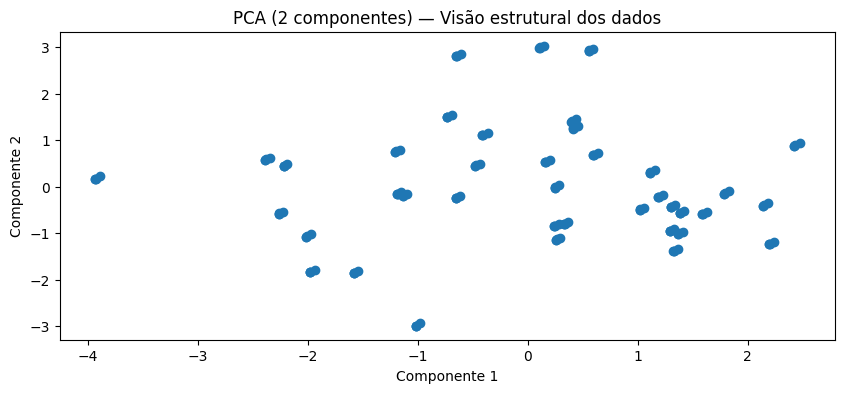

In [8]:

plt.scatter(X_2d[:, 0], X_2d[:, 1])
plt.title("PCA (2 componentes) — Visão estrutural dos dados")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.show()


## 8) Aplicação do KMeans para identificação de tendências

Nesta etapa aplicamos o algoritmo **KMeans**, técnica de aprendizado não supervisionado, com o objetivo de identificar agrupamentos (clusters) de registros com características semelhantes.

Inicialmente, as variáveis numéricas foram padronizadas com `StandardScaler`, pois o KMeans é sensível à escala dos dados. Em seguida, definimos `n_clusters=3` para segmentar o conjunto em três grupos distintos.

O resultado da clusterização foi armazenado na coluna `cluster`, permitindo analisar a distribuição dos registros em cada grupo e explorar possíveis tendências de produtividade.

A aplicação do KMeans com k=3 resultou na formação de três grupos distintos, com 68, 44 e 44 registros, respectivamente.

Observa-se que o cluster 0 concentra a maior parte dos registros, representando aproximadamente 44% do dataset, enquanto os demais clusters apresentam distribuição equilibrada.

Essa segmentação indica que existem padrões estruturais identificáveis no conjunto de dados, sem formação de grupos extremamente pequenos ou desbalanceados. Assim, a clusterização permitiu organizar os registros em perfis distintos de condições climáticas e produtividade.




In [9]:
# Preparação para clusterização: padronização + KMeans (k=3)

X_cluster = df[["precipitation","specific_humidity","relative_humidity","temperature","yield"]].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

kmeans = KMeans(n_clusters=3, random_state=RANDOM_STATE, n_init=10)
df["cluster"] = kmeans.fit_predict(X_scaled)
# Atribui o rótulo do cluster a cada registro para análise posterior

df["cluster"].value_counts()


cluster
0    68
2    44
1    44
Name: count, dtype: int64

## 9) Análise do perfil médio dos clusters

Após a aplicação do KMeans, agrupamos os dados pela variável `cluster` para calcular a média das variáveis numéricas dentro de cada grupo.

Essa análise permite compreender as características médias de cada cluster, identificando diferenças de produtividade e condições climáticas entre os grupos formados.

Dessa forma, é possível interpretar os padrões identificados pela clusterização e relacioná-los às tendências de rendimento agrícola.

A análise do perfil médio dos clusters indica diferenças moderadas de produtividade entre os grupos identificados pelo KMeans.

O cluster 1 apresentou o maior rendimento médio (~57.453), enquanto o cluster 2 registrou o menor (~53.951). A diferença entre os extremos é relativamente pequena quando comparada às diferenças observadas entre os tipos de cultura na etapa de EDA.

Além disso, pequenas variações nas médias de temperatura e precipitação sugerem que condições climáticas podem influenciar o rendimento, porém com impacto menos expressivo do que o tipo de cultura.

Dessa forma, a clusterização permitiu identificar tendências estruturais no dataset, mas reforça que a variável `crop` permanece como principal determinante da produtividade.



In [10]:

cluster_profile = df.groupby("cluster")[["precipitation","specific_humidity","relative_humidity","temperature","yield"]].mean()
cluster_profile


,precipitation,specific_humidity,relative_humidity,temperature,yield
cluster,,,,,
0,2733.517647,18.337647,85.652353,26.118824,56736.544118
1,2359.024545,18.392727,84.145455,26.480909,57453.000000
2,2232.217273,17.805455,83.916364,25.986364,53951.500000


### Conclusões da clusterização

A aplicação do algoritmo KMeans resultou na formação de três clusters distintos, permitindo segmentar os registros com base em características semelhantes de condições climáticas e rendimento.

Observou-se que:
- O cluster com maior média de `yield` (~57.453) representa cenários relativamente mais produtivos.
- O cluster com menor média (~53.951) indica menor produtividade dentro do conjunto analisado.

Entretanto, a diferença média de rendimento entre os clusters mostrou-se moderada quando comparada às diferenças observadas entre os diferentes tipos de cultura. Esse resultado sugere que, embora existam padrões estruturais identificáveis via clusterização, o tipo de cultura permanece como o principal fator determinante da produtividade neste dataset.



## 10) Identificação de outliers utilizando o método IQR

Neste trecho aplicamos o método do **Intervalo Interquartil (IQR)** para identificar possíveis valores discrepantes na variável `yield`.

Inicialmente, calculamos o primeiro quartil (Q1) e o terceiro quartil (Q3), obtendo o IQR como a diferença entre eles. Em seguida, definimos limites inferior e superior com base na regra 1,5 × IQR, que é amplamente utilizada para detecção de outliers.

Por fim, filtramos os registros que se encontram fora desses limites, permitindo quantificar e analisar possíveis cenários de produtividade atípica.

Os limites definidos pelo método IQR foram -80.458,75 (inferior) e 156.305,25 (superior). Como o rendimento não assume valores negativos, apenas o limite superior foi relevante na identificação de valores extremos.

Foram identificados 35 registros como outliers, representando aproximadamente 22% do dataset. Essa proporção relativamente elevada ocorre devido à grande diferença estrutural entre as culturas, especialmente pelos altos valores de rendimento da cultura Oil palm fruit.

Assim, os outliers identificados não indicam necessariamente erro nos dados, mas refletem a heterogeneidade natural do conjunto analisado.




In [11]:

q1 = df["yield"].quantile(0.25)
q3 = df["yield"].quantile(0.75)
iqr = q3 - q1

lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

outliers = df[(df["yield"] < lower) | (df["yield"] > upper)]

print("Limites IQR:", lower, upper)
len(outliers)


Limites IQR: -80458.75 156305.25


35

### Conclusão sobre outliers

A aplicação do método IQR permitiu identificar registros com valores de `yield` fora do intervalo considerado estatisticamente esperado. Esses pontos representam cenários de produtividade atípica dentro do conjunto analisado.

Optou-se por manter os outliers no dataset, pois eles podem refletir variações reais do contexto agrícola e contribuem para que os modelos aprendam a lidar com situações extremas. A remoção desses registros poderia reduzir a capacidade de generalização do modelo ao simplificar excessivamente o problema.



## 11) Preparação dos dados para regressão supervisionada

Nesta etapa organizamos os dados para a modelagem preditiva.

Inicialmente, separamos as variáveis independentes (`X`) da variável alvo (`y`), que corresponde ao `yield`. Em seguida, aplicamos a codificação *one-hot encoding* na variável categórica `crop`, convertendo-a em variáveis numéricas adequadas para os algoritmos de regressão.

Por fim, dividimos o conjunto em dados de treino (80%) e teste (20%) utilizando `train_test_split`, garantindo que o modelo seja avaliado em dados não utilizados no treinamento. Essa separação é uma boa prática fundamental em projetos de Machine Learning supervisionado.

A divisão dos dados resultou em 124 registros para treino e 32 para teste, representando aproximadamente 80% e 20% do dataset, respectivamente, conforme definido no parâmetro `test_size=0.2`.

O conjunto final contém 7 variáveis explicativas, número que resulta da aplicação do *one-hot encoding* na variável categórica `crop`. Como existem quatro categorias de cultura, foram geradas três variáveis binárias adicionais (utilizando `drop_first=True`), evitando multicolinearidade.

Essa estrutura garante base adequada para o treinamento e avaliação dos modelos de regressão supervisionada.



In [12]:
# Separação de variáveis (X) e alvo (y), com one-hot para 'crop'

X = df.drop(columns=["yield", "cluster"], errors="ignore")
y = df["yield"]

X = pd.get_dummies(X, columns=["crop"], drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
# Divisão treino/teste (80/20) para avaliar generalização em dados não vistos
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

X_train.shape, X_test.shape


((124, 7), (32, 7))

## 12) Treinamento e avaliação dos cinco modelos de regressão

Nesta etapa implementamos cinco algoritmos distintos de regressão supervisionada: Linear Regression, Ridge, Lasso, Decision Tree e Random Forest, conforme solicitado no enunciado.

Para cada modelo, utilizamos um `Pipeline` contendo padronização dos dados (`StandardScaler`) e o algoritmo de regressão, garantindo organização e boas práticas no processo de modelagem.

Os modelos foram treinados com os dados de treino e avaliados no conjunto de teste por meio das métricas:

- MAE (Erro Absoluto Médio),
- RMSE (Raiz do Erro Quadrático Médio),
- R² (Coeficiente de Determinação).

Os resultados foram organizados em um DataFrame para comparação objetiva do desempenho, permitindo identificar o modelo mais adequado para prever o rendimento agrícola.

A comparação dos modelos demonstrou desempenho elevado em todos os algoritmos, com valores de R² superiores a 0,99, indicando alta capacidade explicativa.

O modelo LinearRegression apresentou o menor RMSE, sendo considerado o mais adequado para este problema. A proximidade de desempenho entre os modelos lineares e não lineares sugere que a relação entre as variáveis explicativas e o rendimento é predominantemente linear, especialmente devido à forte influência da variável categórica `crop`.



In [17]:
# Definição dos 5 modelos solicitados e avaliação comparativa (MAE, RMSE, R²)

models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(random_state=RANDOM_STATE),
    "Lasso": Lasso(random_state=RANDOM_STATE),
    "DecisionTree": DecisionTreeRegressor(random_state=RANDOM_STATE),
    "RandomForest": RandomForestRegressor(random_state=RANDOM_STATE, n_estimators=300)
}

results = []

for name, model in models.items():
    pipe = Pipeline([
# Pipeline padroniza os dados e aplica o modelo em um fluxo reprodutível
        ("scaler", StandardScaler(with_mean=False)),
        ("model", model)
    ])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
# Métricas: MAE (erro médio absoluto), RMSE (erro quadrático) e R² (variância explicada)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)

    results.append([name, mae, rmse, r2])

results_df = pd.DataFrame(results, columns=["modelo", "MAE", "RMSE", "R2"]).sort_values("RMSE")
results_df


c:\Users\muril\OneDrive\Desktop\FIAP_Fase 5_Tarefa_Cap 1\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.496e+09, tolerance: 6.415e+07
  model = cd_fast.enet_coordinate_descent(


,modelo,MAE,RMSE,R2
0,LinearRegression,3132.796384,4394.165819,0.995022
2,Lasso,3296.670652,4483.453059,0.994818
1,Ridge,3359.141135,4588.133708,0.994573
4,RandomForest,2643.376875,4636.565458,0.994458
3,DecisionTree,3142.531250,5316.346746,0.992714


### Conclusões dos modelos de regressão

A comparação entre os cinco algoritmos demonstrou que o modelo **LinearRegression** apresentou o melhor desempenho preditivo, com:

- RMSE ≈ 4.394  
- R² ≈ 0.995  

O valor elevado de R² indica que aproximadamente 99,5% da variabilidade do `yield` foi explicada pelo modelo, evidenciando forte capacidade de ajuste aos dados. O baixo RMSE reforça a precisão das previsões no conjunto de teste.

Os resultados sugerem que a relação entre as variáveis explicativas e o rendimento possui comportamento predominantemente linear, especialmente devido à forte influência da variável categórica `crop`. Assim, modelos lineares mostraram-se suficientes para capturar a estrutura do problema, sem necessidade de maior complexidade.



## 13) Conclusão Final

O presente trabalho atendeu integralmente aos objetivos propostos no enunciado.

Inicialmente, a análise exploratória (EDA) permitiu compreender a estrutura do dataset, identificar padrões de produtividade entre as culturas e verificar a baixa correlação linear entre as variáveis climáticas e o rendimento.

Em seguida, foram aplicadas técnicas de aprendizado não supervisionado (PCA e KMeans), possibilitando explorar a tendência estrutural dos dados e identificar agrupamentos com características semelhantes de produtividade. Também foram identificados possíveis valores discrepantes por meio do método IQR, garantindo análise crítica dos dados antes da modelagem.

Por fim, cinco modelos de regressão supervisionada foram treinados e avaliados com métricas adequadas (MAE, RMSE e R²), sendo a Regressão Linear o modelo de melhor desempenho.

De forma geral, os resultados indicam que o tipo de cultura (`crop`) é o principal determinante do rendimento (`yield`) neste conjunto de dados, enquanto as variáveis climáticas analisadas apresentam influência limitada. Assim, o estudo demonstrou coerência metodológica entre análise exploratória, técnicas não supervisionadas e modelagem preditiva, proporcionando maior clareza sobre os fatores associados à produtividade agrícola.

